In [382]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, NonNegativeReals, NonNegativeIntegers, Binary, SolverFactory, minimize, ConstraintList

We are creating a covering problem to minimize total cost of public facilities in a city. We create functions to collect user inputs for city generation, generate the city data matrix and calculate distances, generate the coverage matrices, build the optimization model, run the solver, and visualize the results.

In [383]:
# FUNCTION 1: COLLECT USER INPUTS
def get_user_inputs():
    # MODIFY THESE VALUES
    inputs = {
        # City Parameters
        'population': 800000,           # Total city population
        'n_neighborhoods': 40,          # Number of neighborhoods
        'budget_per_capita': 3000,      # Budget per resident ($)

        # Facility Coverage Requirements (in miles)
        'fire_coverage': 2.5,           # Fire stations X miles
        'police_coverage': 3.5,         # Police stations within X miles
        'hospital_coverage': 4,       # Hospitals within X miles

        # Facility Costs (in millions $)
        'fire_cost': 15,              # Cost per fire station
        'police_cost': 25,             # Cost per police station
        'hospital_cost': 150.0,         # Cost per hospital

        # Minimum Requirements
        'min_fire': 2,                  # At least 2 fire stations
        'min_police': 2,                # At least 2 police stations
        'min_hospital': 1,              # At least 1 hospital

        # Budget Allocation Limits (% of total budget)
        'fire_budget_pct': 0.40,        # Max 40% on fire
        'police_budget_pct': 0.30,      # Max 30% on police
        'hospital_budget_pct': 0.50,    # Max 50% on hospitals

    }

    # Calculate total budget
    inputs['total_budget'] = (inputs['population'] * inputs['budget_per_capita']) / 1_000_000  # in millions

    return inputs

In [384]:
# FUNCTION 2: GENERATE CITY DATA
def generate_city_data(n_neighborhoods, n_candidates=None):

    #Generate random city with neighborhoods and candidate facility locations
    #Returns: neighborhoods dict, candidates dict, distance matrix
    if n_candidates is None:
        n_candidates = int(n_neighborhoods * 1.5)  # 50% more candidates than neighborhoods

    np.random.seed(42)  # For reproducibility

    # Generate neighborhood locations (x, y coordinates in a 10x10 mile grid)
    neighborhoods = {}
    for i in range(n_neighborhoods):
        neighborhoods[i] = {
            'x': np.random.uniform(0, 10),
            'y': np.random.uniform(0, 10),
            'population': np.random.randint(3000, 8000)
        }

    # Generate candidate facility locations
    candidates = {}
    for j in range(n_candidates):
        candidates[j] = {
            'x': np.random.uniform(0, 10),
            'y': np.random.uniform(0, 10)
        }

    # Calculate distance matrix (neighborhoods x candidates)
    distances = np.zeros((n_neighborhoods, n_candidates))
    for i in range(n_neighborhoods):
        for j in range(n_candidates):
            dx = neighborhoods[i]['x'] - candidates[j]['x']
            dy = neighborhoods[i]['y'] - candidates[j]['y']
            distances[i, j] = np.sqrt(dx**2 + dy**2)

    return neighborhoods, candidates, distances

In [385]:
# FUNCTION 3: GENERATE COVERAGE MATRICES
def generate_coverage(distances, fire_radius, police_radius, hospital_radius):
    #Generate binary coverage matrices
    #coverage[i,j] = 1 if candidate j covers neighborhood i, 0 otherwise
    coverage = {
        'fire': (distances <= fire_radius).astype(int),
        'police': (distances <= police_radius).astype(int),
        'hospital': (distances <= hospital_radius).astype(int)
    }

    return coverage

In [386]:

# FUNCTION 4: BUILD OPTIMIZATION MODEL
def build_model(inputs, neighborhoods, candidates, coverage):
    #Decision Variables:
     #   x[facility_type, location] = 1 if we build facility at location, 0 otherwise
    #Objective:
     #   Minimize total cost of facilities
    #Constraints:
     #   - Coverage: Every neighborhood must be covered by each facility type
      #  - Budget: Total cost <= total budget
       # - Category budgets: Cost per facility type <= category budget limit
       # - Minimum facilities: Must build at least min_x of each type
    model = ConcreteModel()
    # Sets
    facility_types = ['fire', 'police', 'hospital']
    neighborhood_ids = list(neighborhoods.keys())
    candidate_ids = list(candidates.keys())
    # Decision Variables: Binary variable for each facility type at each candidate location
    model.x_fire = Var(candidate_ids, within=Binary)
    model.x_police = Var(candidate_ids, within=Binary)
    model.x_hospital = Var(candidate_ids, within=Binary)

    # Objective: Minimize total cost
    total_cost = (
        inputs['fire_cost'] * sum(model.x_fire[j] for j in candidate_ids) +
        inputs['police_cost'] * sum(model.x_police[j] for j in candidate_ids) +
        inputs['hospital_cost'] * sum(model.x_hospital[j] for j in candidate_ids)
    )
    model.cost = Objective(expr=total_cost, sense=minimize)

    # Constraints
    model.constraints = ConstraintList()
    # Coverage Constraints: Every neighborhood must be covered
    for i in neighborhood_ids:
        # Fire coverage
        model.constraints.add(
            sum(coverage['fire'][i, j] * model.x_fire[j] for j in candidate_ids) >= 1
        )
        # Police coverage
        model.constraints.add(
            sum(coverage['police'][i, j] * model.x_police[j] for j in candidate_ids) >= 1
        )
        # Hospital coverage
        model.constraints.add(
            sum(coverage['hospital'][i, j] * model.x_hospital[j] for j in candidate_ids) >= 1
        )

    # Budget Constraints
    # Total budget
    model.constraints.add(total_cost <= inputs['total_budget'])

    # Category budgets
    model.constraints.add(
        inputs['fire_cost'] * sum(model.x_fire[j] for j in candidate_ids)
        <= inputs['fire_budget_pct'] * inputs['total_budget']
    )
    model.constraints.add(
        inputs['police_cost'] * sum(model.x_police[j] for j in candidate_ids)
        <= inputs['police_budget_pct'] * inputs['total_budget']
    )
    model.constraints.add(
        inputs['hospital_cost'] * sum(model.x_hospital[j] for j in candidate_ids)
        <= inputs['hospital_budget_pct'] * inputs['total_budget']
    )

    # Minimum facility requirements
    model.constraints.add(sum(model.x_fire[j] for j in candidate_ids) >= inputs['min_fire'])
    model.constraints.add(sum(model.x_police[j] for j in candidate_ids) >= inputs['min_police'])
    model.constraints.add(sum(model.x_hospital[j] for j in candidate_ids) >= inputs['min_hospital'])

    return model, candidate_ids

In [387]:
# FUNCTION 5: SOLVE MODEL
def solve_model(model):
    solver = SolverFactory('cbc')
    solver.set_executable('/usr/bin/cbc')
    result = solver.solve(model, tee=False)
    return result


In [388]:
# FUNCTION 6: EXTRACT RESULTS
def extract_results(model, inputs, candidate_ids):
    #Extract solution from solved model
    results = {
        'fire_locations': [j for j in candidate_ids if model.x_fire[j].value > 0.5],
        'police_locations': [j for j in candidate_ids if model.x_police[j].value > 0.5],
        'hospital_locations': [j for j in candidate_ids if model.x_hospital[j].value > 0.5],
    }

    results['fire_count'] = len(results['fire_locations'])
    results['police_count'] = len(results['police_locations'])
    results['hospital_count'] = len(results['hospital_locations'])

    results['fire_cost'] = results['fire_count'] * inputs['fire_cost']
    results['police_cost'] = results['police_count'] * inputs['police_cost']
    results['hospital_cost'] = results['hospital_count'] * inputs['hospital_cost']
    results['total_cost'] = results['fire_cost'] + results['police_cost'] + results['hospital_cost']

    return results

In [389]:
# FUNCTION 7: VISUALIZE SOLUTION
def visualize_solution(neighborhoods, candidates, results, inputs):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # LEFT PLOT: Map
    ax1.set_xlim(-0.5, 10.5)
    ax1.set_ylim(-0.5, 10.5)
    ax1.set_aspect('equal')
    ax1.set_xlabel('Distance (miles)', fontsize=11)
    ax1.set_ylabel('Distance (miles)', fontsize=11)
    ax1.set_title('Optimized Facility Placement', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot neighborhoods (gray dots)
    for n_id, n_data in neighborhoods.items():
        ax1.scatter(n_data['x'], n_data['y'], s=100, c='lightgray',
                   edgecolors='gray', linewidths=1, alpha=0.6, zorder=1)

    # Plot facilities
    for j in results['fire_locations']:
        ax1.scatter(candidates[j]['x'], candidates[j]['y'],
                   s=200, c='red', marker='^', edgecolors='black',
                   linewidths=1.5, label='Fire' if j == results['fire_locations'][0] else '', zorder=3)

    for j in results['police_locations']:
        ax1.scatter(candidates[j]['x'], candidates[j]['y'],
                   s=180, c='blue', marker='s', edgecolors='black',
                   linewidths=1.5, label='Police' if j == results['police_locations'][0] else '', zorder=3)

    for j in results['hospital_locations']:
        ax1.scatter(candidates[j]['x'], candidates[j]['y'],
                   s=250, c='green', marker='P', edgecolors='black',
                   linewidths=1.5, label='Hospital' if j == results['hospital_locations'][0] else '', zorder=3)

    ax1.legend(loc='upper right', fontsize=10)

    # RIGHT PLOT: Statistics
    ax2.axis('off')

    ax2.text(0.5, 0.95, 'Optimization Results',
            ha='center', fontsize=14, fontweight='bold', transform=ax2.transAxes)

    y = 0.85
    ax2.text(0.1, y, f"Population: {inputs['population']:,}", fontsize=10, transform=ax2.transAxes)
    y -= 0.06
    ax2.text(0.1, y, f"Total Budget: ${inputs['total_budget']:.1f}M", fontsize=10, transform=ax2.transAxes)
    y -= 0.06
    ax2.text(0.1, y, f"Budget Used: ${results['total_cost']:.1f}M ({results['total_cost']/inputs['total_budget']*100:.1f}%)",
            fontsize=10, color='red', transform=ax2.transAxes)

    y -= 0.1
    ax2.text(0.1, y, 'Facilities Built:', fontsize=11, fontweight='bold', transform=ax2.transAxes)

    y -= 0.06
    ax2.text(0.1, y, f"Fire Stations: {results['fire_count']} (${results['fire_cost']:.1f}M)",
            fontsize=10, color='red', transform=ax2.transAxes)

    y -= 0.05
    ax2.text(0.1, y, f"Police Stations: {results['police_count']} (${results['police_cost']:.1f}M)",
            fontsize=10, color='blue', transform=ax2.transAxes)

    y -= 0.05
    ax2.text(0.1, y, f"Hospitals: {results['hospital_count']} (${results['hospital_cost']:.1f}M)",
            fontsize=10, color='green', transform=ax2.transAxes)

    y -= 0.1
    ax2.text(0.1, y, 'Coverage Requirements:', fontsize=11, fontweight='bold', transform=ax2.transAxes)

    y -= 0.05
    ax2.text(0.1, y, f"Fire: {inputs['fire_coverage']} miles", fontsize=9, transform=ax2.transAxes)

    y -= 0.04
    ax2.text(0.1, y, f"Police: {inputs['police_coverage']} miles", fontsize=9, transform=ax2.transAxes)

    y -= 0.04
    ax2.text(0.1, y, f" Hospital: {inputs['hospital_coverage']} miles", fontsize=9, transform=ax2.transAxes)

    y -= 0.04
    ax2.text(0.1, y, f"All {len(neighborhoods)} neighborhoods covered",
            fontsize=9, color='green', fontweight='bold', transform=ax2.transAxes)

    plt.tight_layout()
    plt.savefig('city_optimization.png', dpi=300, bbox_inches='tight')
    print("\nVisualization saved as: city_optimization.png")
    plt.show()


[1/6] Collecting user inputs...
Population: 800,000
Total Budget: $2400.0M
Neighborhoods: 40

[2/6] Generating city geography...
Created 40 neighborhoods
Generated 60 candidate locations

[3/6] Calculating coverage matrices...
Coverage matrices created

[4/6] Building optimization model...
Model built with 180 decision variables

[5/6] Solving optimization problem...
Solution Status: ok

[6/6] Extracting results...

Total Budget: $2400.0M
Total Cost: $640.0M (26.7%)
Remaining Budget: $1760.0M

Facilities Built:
  Fire Stations:    6 × $15.0M = $90.0M
  Police Stations:  4 × $25.0M = $100.0M
  Hospitals:        3 × $150.0M = $450.0M

Per Capita Service:
  1 Fire Station per 133,333 residents
  1 Police Station per 200,000 residents
  1 Hospital per 266,667 residents

[7/7] Creating visualization...

Visualization saved as: city_optimization.png


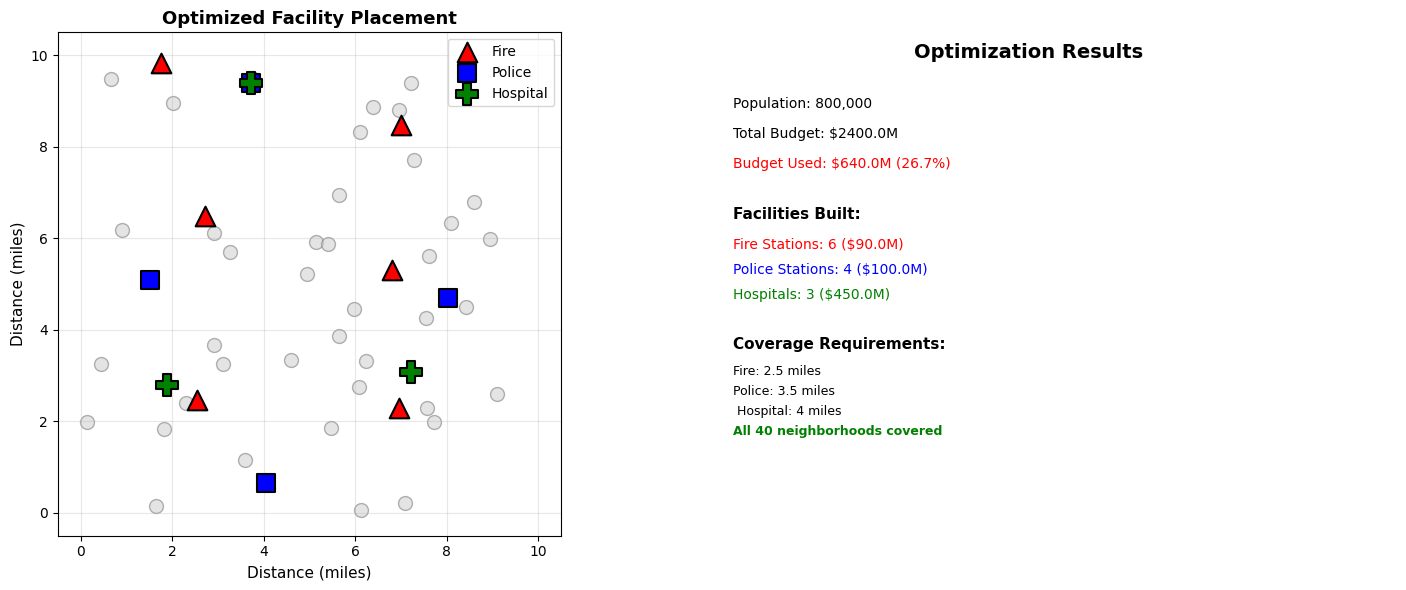

In [390]:
# FUNCTION EXECUTION
def main():
    # Step 1: Get user inputs
    print("\n[1/6] Collecting user inputs...")
    inputs = get_user_inputs()
    print(f"Population: {inputs['population']:,}")
    print(f"Total Budget: ${inputs['total_budget']:.1f}M")
    print(f"Neighborhoods: {inputs['n_neighborhoods']}")

    # Step 2: Generate city data
    print("\n[2/6] Generating city geography...")
    neighborhoods, candidates, distances = generate_city_data(inputs['n_neighborhoods'])
    print(f"Created {len(neighborhoods)} neighborhoods")
    print(f"Generated {len(candidates)} candidate locations")

    # Step 3: Generate coverage matrices
    print("\n[3/6] Calculating coverage matrices...")
    coverage = generate_coverage(distances,
                                 inputs['fire_coverage'],
                                 inputs['police_coverage'],
                                 inputs['hospital_coverage'])
    print(f"Coverage matrices created")

    # Step 4: Build optimization model
    print("\n[4/6] Building optimization model...")
    model, candidate_ids = build_model(inputs, neighborhoods, candidates, coverage)
    print(f"Model built with {len(candidate_ids)*3} decision variables")

    # Step 5: Solve
    print("\n[5/6] Solving optimization problem...")
    result = solve_model(model)
    print(f"Solution Status: {result.solver.status}")

    # Step 6: Extract and display results
    print("\n[6/6] Extracting results...")
    results = extract_results(model, inputs, candidate_ids)

    print(f"\nTotal Budget: ${inputs['total_budget']:.1f}M")
    print(f"Total Cost: ${results['total_cost']:.1f}M ({results['total_cost']/inputs['total_budget']*100:.1f}%)")
    print(f"Remaining Budget: ${inputs['total_budget'] - results['total_cost']:.1f}M")

    print("\nFacilities Built:")
    print(f"  Fire Stations:   {results['fire_count']:2} × ${inputs['fire_cost']:.1f}M = ${results['fire_cost']:.1f}M")
    print(f"  Police Stations: {results['police_count']:2} × ${inputs['police_cost']:.1f}M = ${results['police_cost']:.1f}M")
    print(f"  Hospitals:       {results['hospital_count']:2} × ${inputs['hospital_cost']:.1f}M = ${results['hospital_cost']:.1f}M")

    print("\nPer Capita Service:")
    print(f"  1 Fire Station per {inputs['population']/results['fire_count']:,.0f} residents")
    print(f"  1 Police Station per {inputs['population']/results['police_count']:,.0f} residents")
    print(f"  1 Hospital per {inputs['population']/results['hospital_count']:,.0f} residents")

    # Visualize
    print("\n[7/7] Creating visualization...")
    visualize_solution(neighborhoods, candidates, results, inputs)

    return model, results

# Run the optimization
if __name__ == "__main__":
    model, results = main()